In [ ]:
!pip install selenium
!pip install beautifulsoup4 requests scrapy selenium pandas numpy scikit-learn tensorflow torch gensim
!apt-get update
!apt install chromium-chromedriver

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

In [50]:
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0, 'C:/Users/ahmad/Driver')

cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


In [53]:
# testing chromedriver
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

# Setup Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Initialize ChromeDriver
driver = webdriver.Chrome(service = webdriver.ChromeService(port=9515), options=chrome_options)

# Test the driver
driver.get('https://www.google.com')
print(driver.title)  # Should print "Google"

# Don't forget to quit the driver
driver.quit()


Google


In [54]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time

# Function to scrape arXiv using arXiv API
def scrape_arxiv():
    url = "http://export.arxiv.org/api/query?search_query=all:cybersecurity+AND+all:AI&start=0&max_results=100"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'xml')
    entries = soup.find_all('entry')
    data = []
    for entry in entries:
        title = entry.title.text
        authors = [author.text for author in entry.find_all('author')]
        abstract = entry.summary.text
        published = entry.published.text
        data.append({'Title': title, 'Authors': authors, 'Abstract': abstract, 'Published': published})
    return pd.DataFrame(data)

# Function to scrape IEEE Xplore using Selenium
def scrape_ieee():
    options = Options()
    options.headless = True
    # service = webdriver.ChromeService(port=9515)
    # driver = webdriver.Chrome(service=service, options=options)
    driver = webdriver.Chrome(service = webdriver.ChromeService(port=9515), options=chrome_options)
    driver.get('https://ieeexplore.ieee.org/search/searchresult.jsp?queryText=cybersecurity%20AI')
    time.sleep(3)  # Allow the page to load

    articles = driver.find_elements(By.CLASS_NAME, 'List-results-items')
    data = []
    for article in articles:
        try:
            title = article.find_element(By.CLASS_NAME, 'title').text
            authors = article.find_element(By.CLASS_NAME, 'author').text
            abstract = article.find_element(By.CLASS_NAME, 'abstract').text
            data.append({'Title': title, 'Authors': authors, 'Abstract': abstract})
        except:
            continue
    driver.quit()
    return pd.DataFrame(data)


In [55]:
# Function to scrape Springer using Springer API
def scrape_springer():
    api_key = 'bdc1481535ac2b4d5afa6eff05309d17'
    url = f"http://api.springernature.com/meta/v2/json?q=cybersecurity+AI&api_key={api_key}"
    response = requests.get(url)
    articles = response.json()['records']
    data = []
    for article in articles:
        title = article['title']
        authors = [author['creator'] for author in article['creators']]
        abstract = article['abstract']
        published = article['publicationDate']
        data.append({'Title': title, 'Authors': authors, 'Abstract': abstract, 'Published': published})
    return pd.DataFrame(data)

# Collect data from all sources
df_arxiv = scrape_arxiv()
df_ieee = scrape_ieee()
df_springer = scrape_springer()

# Combine all data into a single DataFrame
df = pd.concat([df_arxiv, df_ieee, df_springer], ignore_index=True)
df.to_csv('articles.csv', index=False)

In [56]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

# Load the data
df = pd.read_csv('articles.csv')

# Text preprocessing function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.lower().split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

# Apply preprocessing
df['Cleaned_Abstract'] = df['Abstract'].apply(preprocess_text)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['Cleaned_Abstract']).toarray()

# Encode labels (if you have any categorical labels)
# For this example, let's assume we're categorizing abstracts into 'AI' and 'Cybersecurity'
df['Category'] = df['Title'].apply(lambda x: 'AI' if 'AI' in x else 'Cybersecurity')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [61]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f'Naive Bayes Accuracy: {nb_accuracy * 100:.2f}%')

# Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f'SVM Accuracy: {svm_accuracy * 100:.2f}%')

# Deep Learning with BERT
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Tokenize data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Prepare dataset for BERT

# Assuming you performed train_test_split as follows:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, range(len(df)), test_size=0.2, random_state=42
)

# Now use the indices from train_test_split:
train_texts = df.loc[indices_train, 'Cleaned_Abstract'].tolist()
test_texts = df.loc[indices_test, 'Cleaned_Abstract'].tolist()
train_labels = y_train.tolist()
test_labels = y_test.tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
test_dataset = Dataset(test_encodings, test_labels)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train and evaluate
trainer.train()
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
bert_accuracy = accuracy_score(test_labels, pred_labels)
print(f'BERT Accuracy: {bert_accuracy * 100:.2f}%')


Naive Bayes Accuracy: 45.45%
SVM Accuracy: 45.45%


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


BERT Accuracy: 45.45%


In [62]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

# Prepare data for LDA
texts = [text.split() for text in df['Cleaned_Abstract']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Print the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.009*"may" + 0.008*"cardiac" + 0.007*"tool" + 0.006*"need" + 0.005*"cybersecurity" + 0.005*"simulator" + 0.004*"ai" + 0.004*"artificial" + 0.004*"new" + 0.004*"provide"')
(1, '0.025*"ai" + 0.010*"cybersecurity" + 0.009*"model" + 0.007*"paper" + 0.007*"intelligence" + 0.007*"artificial" + 0.006*"system" + 0.005*"research" + 0.005*"data" + 0.005*"threat"')
(2, '0.023*"ai" + 0.018*"cybersecurity" + 0.006*"potential" + 0.006*"cyber" + 0.006*"technology" + 0.005*"research" + 0.005*"security" + 0.005*"provide" + 0.005*"artificial" + 0.005*"quantum"')
(3, '0.015*"cybersecurity" + 0.013*"threat" + 0.011*"security" + 0.008*"ai" + 0.007*"ethical" + 0.006*"cloud" + 0.006*"data" + 0.005*"challenge" + 0.005*"computing" + 0.005*"cybersecurity,"')
(4, '0.019*"cybersecurity" + 0.008*"system" + 0.007*"attack" + 0.007*"security" + 0.005*"model" + 0.005*"ai" + 0.005*"threat" + 0.005*"digital" + 0.005*"approach" + 0.005*"critical"')
(5, '0.012*"cybersecurity" + 0.010*"ai" + 0.006*"detection" + 0.005

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


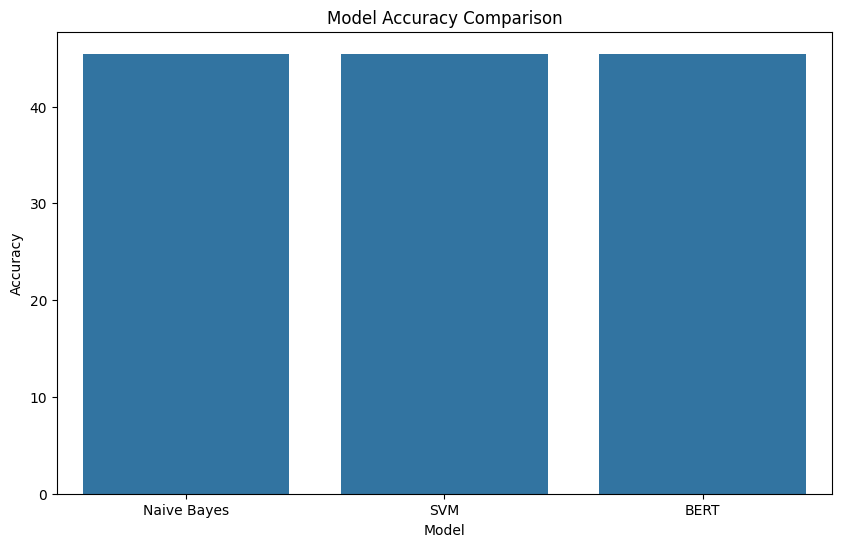

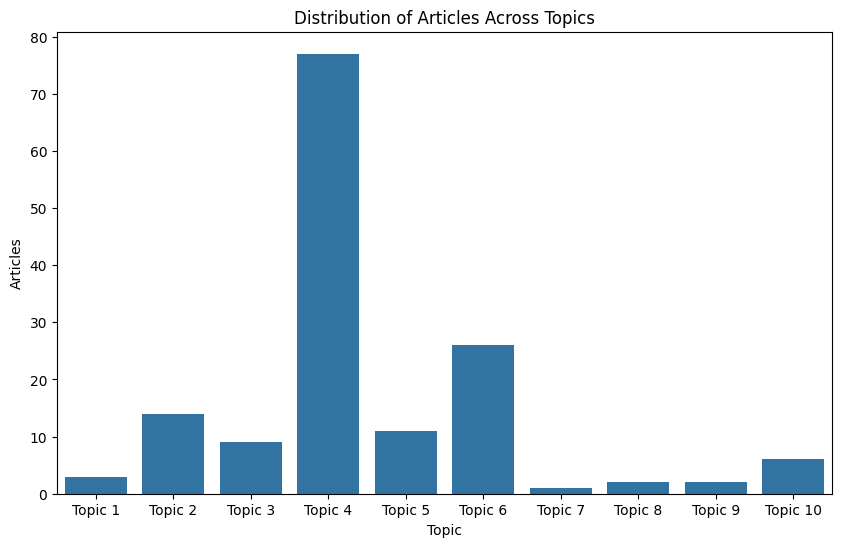

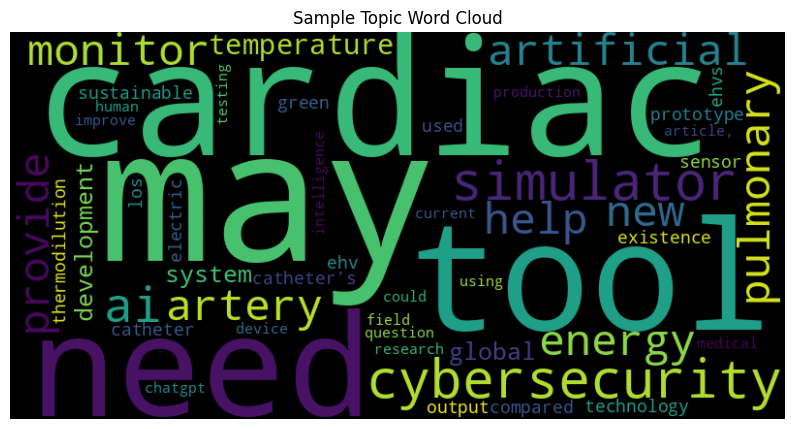

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Mock data for visual aids
model_accuracy = {
    'Model': ['Naive Bayes', 'SVM', 'BERT'],
    'Accuracy': [nb_accuracy * 100, svm_accuracy * 100, bert_accuracy * 100]
}

topic_distribution = {
    'Topic': [f'Topic {i+1}' for i in range(10)],
    'Articles': [len([doc for doc in corpus if i in [word_id for word_id, _ in doc]]) for i in range(10)]
}

# Create DataFrames
df_accuracy = pd.DataFrame(model_accuracy)
df_topics = pd.DataFrame(topic_distribution)

# Plot model accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df_accuracy)
plt.title('Model Accuracy Comparison')
plt.savefig('model_accuracy.png')

# Plot topic distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Topic', y='Articles', data=df_topics)
plt.title('Distribution of Articles Across Topics')
plt.savefig('topic_distribution.png')

# Create word cloud for a topic
words = lda_model.show_topic(0, 50)
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(dict(words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Sample Topic Word Cloud')
plt.savefig('sample_topic_word_cloud.png')
